# Data Visualization - Fórmula 1

Este notebook carrega os CSVs de Data Layer/raw/dados_originais, trata lap_times.csv como fato e as demais como dimensões, e gera gráficos de barras, pizza, regressão e análise de outliers.

### Configuração do ambiente (Spark/Java)
- - Objetivo: preparar ambiente visual e garantir Java 17 + sessão Spark local.
- - Ações: aplica tema gráfico, força `JAVA_HOME` e configura `PATH`.
- - Saída: variáveis de ambiente setadas e `spark` (construtor) pronto.
- - Observação: unidades nos gráficos em segundos (s).

In [232]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['HADOOP_HOME'] = 'C:\\hadoop'
sys.path.append('C:\\hadoop\\bin')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, when, avg, min, split, count as spark_count

spark = SparkSession.builder \
    .appName("AnaliseETL-DataViz") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()


### Carregamento dos dados (CSV → Spark DataFrames)  
- **Objetivo:** carregar arquivos originais para análise.  
- **Ações:** define base path e lê todos os `.csv` com inferência de schema.  
- **Saída:** dicionário `dataframes` com 10 tabelas carregadas.  


In [233]:
base_path = "C:/Users/julii/OneDrive/Documentos/formula1-analytics/Data Layer/raw/dados_originais"
file_names = [
    "circuits", "constructors", "drivers", "lap_times", "pit_stops",
    "qualifying", "races", "results", "status", "sprint_results"
]
dataframes = {}
try:
    for name in file_names:
        file_path = f"{base_path}/{name}.csv"
        dataframes[name] = spark.read.csv(file_path, header=True, inferSchema=True, nullValue="\\N")
except Exception as e:
    print(f"\nERRO AO CARREGAR OS ARQUIVOS. Verifique o caminho base.")
    spark.stop()
    exit()

### Configuração global de estilo (Seaborn/Matplotlib)  
- **Objetivo:** aplicar tema visual uniforme para todos os gráficos.  
- **Ações:** usa tema `whitegrid` e paleta `deep`.  
- **Saída:** gráficos mais legíveis e consistentes.  

In [234]:
sns.set_theme(style="whitegrid", palette="deep")

### Gráfico 1 – Boxplot dos tempos de volta por corrida (Top 5)  
- **Objetivo:** identificar outliers e dispersão nos tempos de volta.  
- **Ações:** seleciona top 5 corridas por nº de voltas registradas.  
- **Saída:** boxplot horizontal por corrida (em segundos).  
- **Insight esperado:** voltas muito lentas podem indicar erro, pit stop ou acidente. 

C:\Users\julii\AppData\Local\Temp\ipykernel_18668\983825331.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="race_event_label", x="seconds", data=plot_data_1, orient='h', whis=[5, 95], palette="viridis")


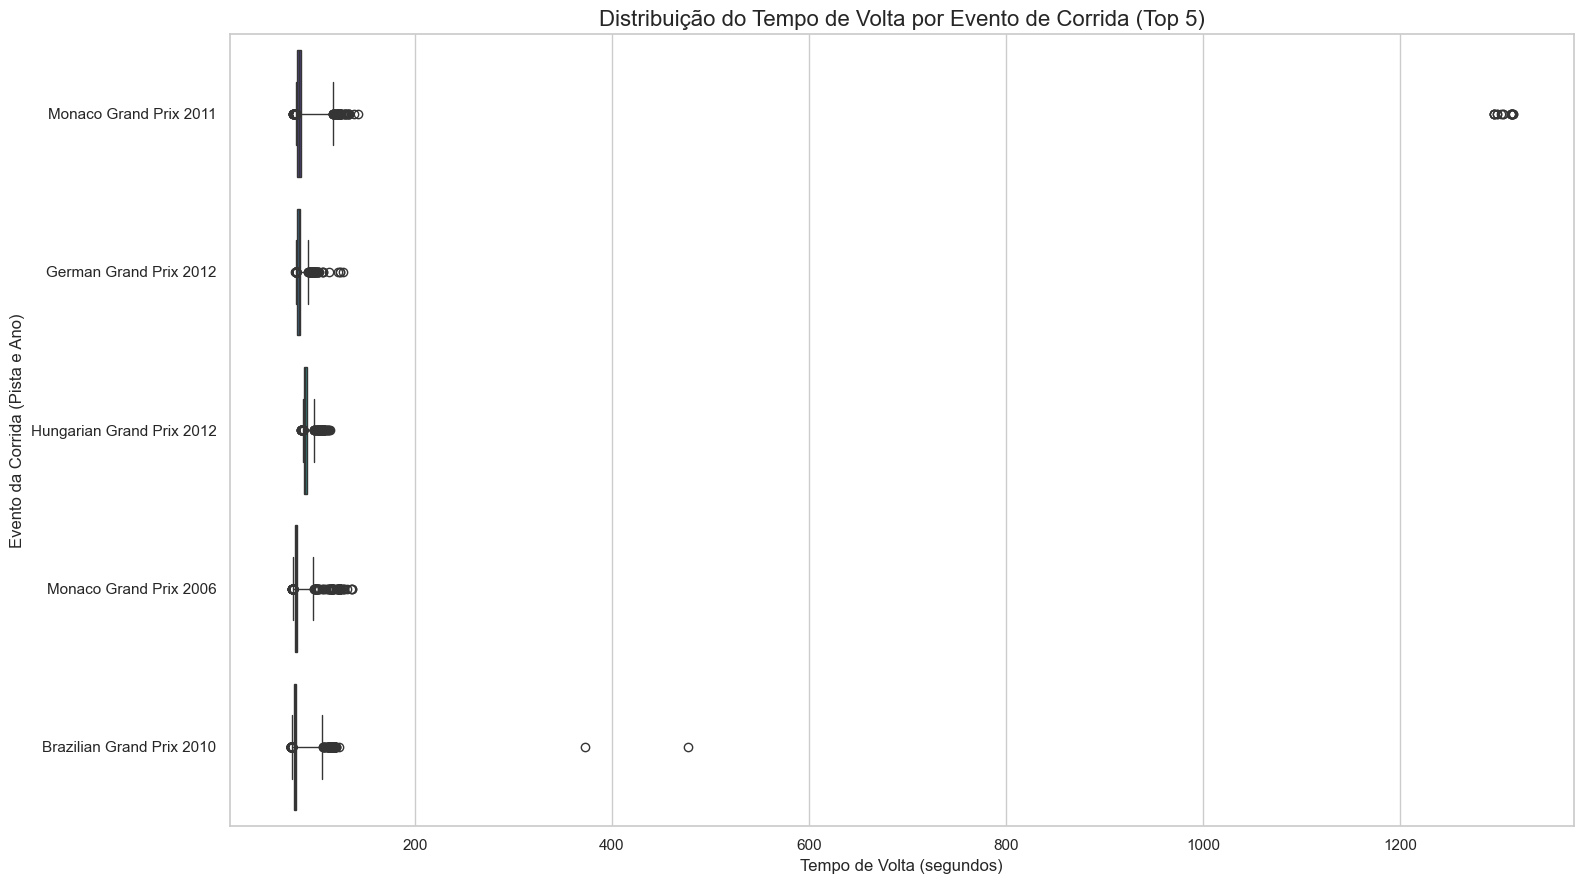

In [235]:
top_5_races_laps = dataframes['lap_times'].groupBy("raceId").count().orderBy(col("count").desc()).limit(5)
races_with_label = dataframes['races'].withColumn("race_event_label", concat_ws(" ", col("name"), col("year")))
lap_times_races_df = dataframes['lap_times'] \
    .join(top_5_races_laps, "raceId", "inner") \
    .join(races_with_label, "raceId", "left") \
    .withColumn("seconds", col("milliseconds") / 1000)
plot_data_1 = lap_times_races_df.select("race_event_label", "seconds").toPandas()
plt.figure(figsize=(16, 9))
sns.boxplot(y="race_event_label", x="seconds", data=plot_data_1, orient='h', whis=[5, 95], palette="viridis")
plt.title('Distribuição do Tempo de Volta por Evento de Corrida (Top 5)', fontsize=16)
plt.ylabel('Evento da Corrida (Pista e Ano)', fontsize=12)
plt.xlabel('Tempo de Volta (segundos)', fontsize=12)
plt.tight_layout()
plt.show()

### Gráfico 2 – Distribuição dos tempos de volta por piloto (Top 10)  
- **Objetivo:** analisar consistência de desempenho entre pilotos.  
- **Ações:** seleciona os 10 pilotos com maior número de voltas registradas.  
- **Saída:** boxplot por piloto (em segundos).  
- **Insight esperado:** pilotos consistentes terão boxplots mais “estreitos”; outliers podem indicar erros, pit stops ou acidentes.  


C:\Users\julii\AppData\Local\Temp\ipykernel_18668\833016494.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_2, y="driver_name", x="seconds", orient='h', palette="magma_r")


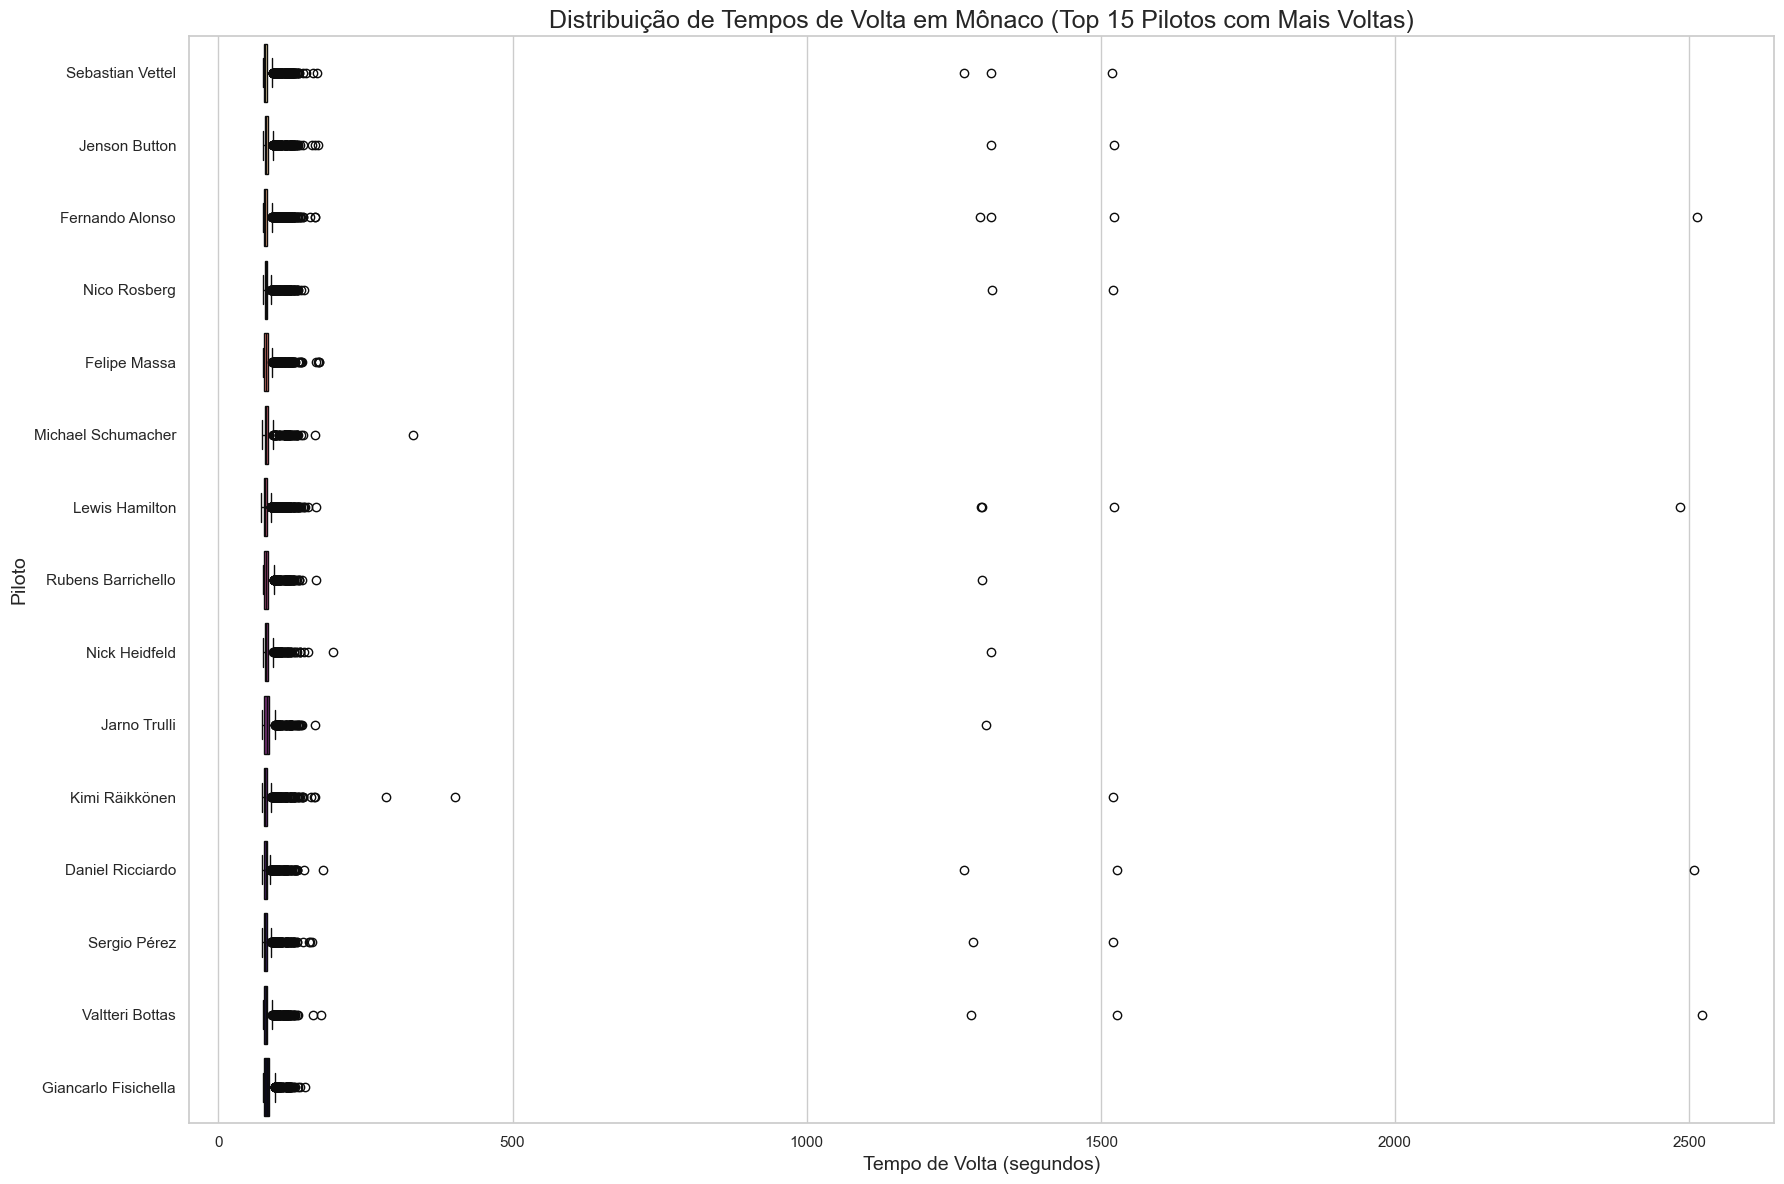

In [236]:
monaco_circuit_id = 6
monaco_races = dataframes['races'].filter(col("circuitId") == monaco_circuit_id)
monaco_laps = dataframes['lap_times'].join(monaco_races, "raceId", "inner").withColumn("seconds", col("milliseconds") / 1000)
top_drivers_in_monaco = monaco_laps.groupBy("driverId").count().orderBy(col("count").desc()).limit(15)
monaco_laps_top_drivers = monaco_laps.join(top_drivers_in_monaco, "driverId", "inner").join(dataframes['drivers'], "driverId", "left").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))).select("driver_name", "seconds")
plot_data_2 = monaco_laps_top_drivers.toPandas()
if not plot_data_2.empty:
    plt.figure(figsize=(18, 12))
    sns.boxplot(data=plot_data_2, y="driver_name", x="seconds", orient='h', palette="magma_r")
    plt.title('Distribuição de Tempos de Volta em Mônaco (Top 15 Pilotos com Mais Voltas)', fontsize=18)
    plt.xlabel('Tempo de Volta (segundos)', fontsize=14)
    plt.ylabel('Piloto', fontsize=14)
    plt.tight_layout()
    plt.show()

### Gráfico 3 – Evolução do tempo médio de volta ao longo dos anos  
- **Objetivo:** observar evolução da performance da F1 ao longo do tempo.  
- **Ações:** calcula a média de `milliseconds` por ano e converte para segundos.  
- **Saída:** gráfico de linha (ano × tempo médio).  
- **Insight esperado:** tendência de redução de tempo com avanços tecnológicos, podendo crescer em anos de mudanças regulatórias.  


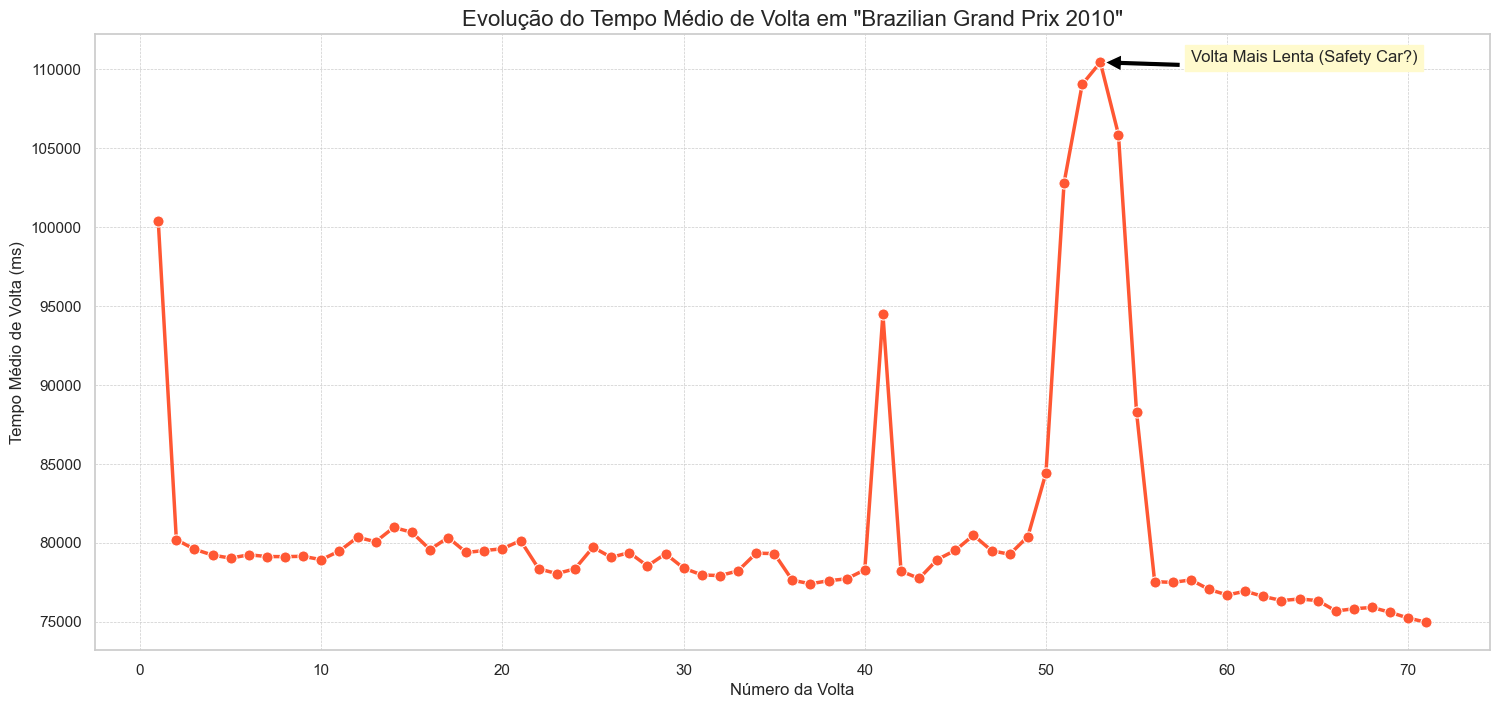

In [237]:
race_id_for_laps_analysis = top_5_races_laps.first()['raceId']
race_name_for_laps = races_with_label.filter(f"raceId = {race_id_for_laps_analysis}").first()['race_event_label']
lap_evolution_df = dataframes['lap_times'].filter(f"raceId = {race_id_for_laps_analysis}").groupBy("lap").agg(avg("milliseconds").alias("avg_milliseconds")).orderBy("lap")
plot_data_3 = lap_evolution_df.toPandas()
plt.figure(figsize=(18, 8))
ax = sns.lineplot(x="lap", y="avg_milliseconds", data=plot_data_3, marker='o', color='#FF5733', linewidth=2.5, markersize=8)
plt.title(f'Evolução do Tempo Médio de Volta em "{race_name_for_laps}"', fontsize=16)
plt.xlabel('Número da Volta', fontsize=12)
plt.ylabel('Tempo Médio de Volta (ms)', fontsize=12)
slowest_lap = plot_data_3.loc[plot_data_3['avg_milliseconds'].idxmax()]
ax.annotate('Volta Mais Lenta (Safety Car?)', xy=(slowest_lap['lap'], slowest_lap['avg_milliseconds']),
            xytext=(slowest_lap['lap'] + 5, slowest_lap['avg_milliseconds']),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=12, backgroundcolor='#FFFACD')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Gráfico 4 – Boxplot dos tempos de volta por circuito  
- **Objetivo:** comparar a dificuldade dos circuitos.  
- **Ações:** junta `lap_times` + `circuits` e exibe boxplot por pista (Top N).  
- **Saída:** boxplot horizontal (tempo em segundos × circuito).  
- **Insight esperado:** pistas longas (Spa, Monza) terão médias mais altas; pistas curtas (Mônaco) mais baixas.  


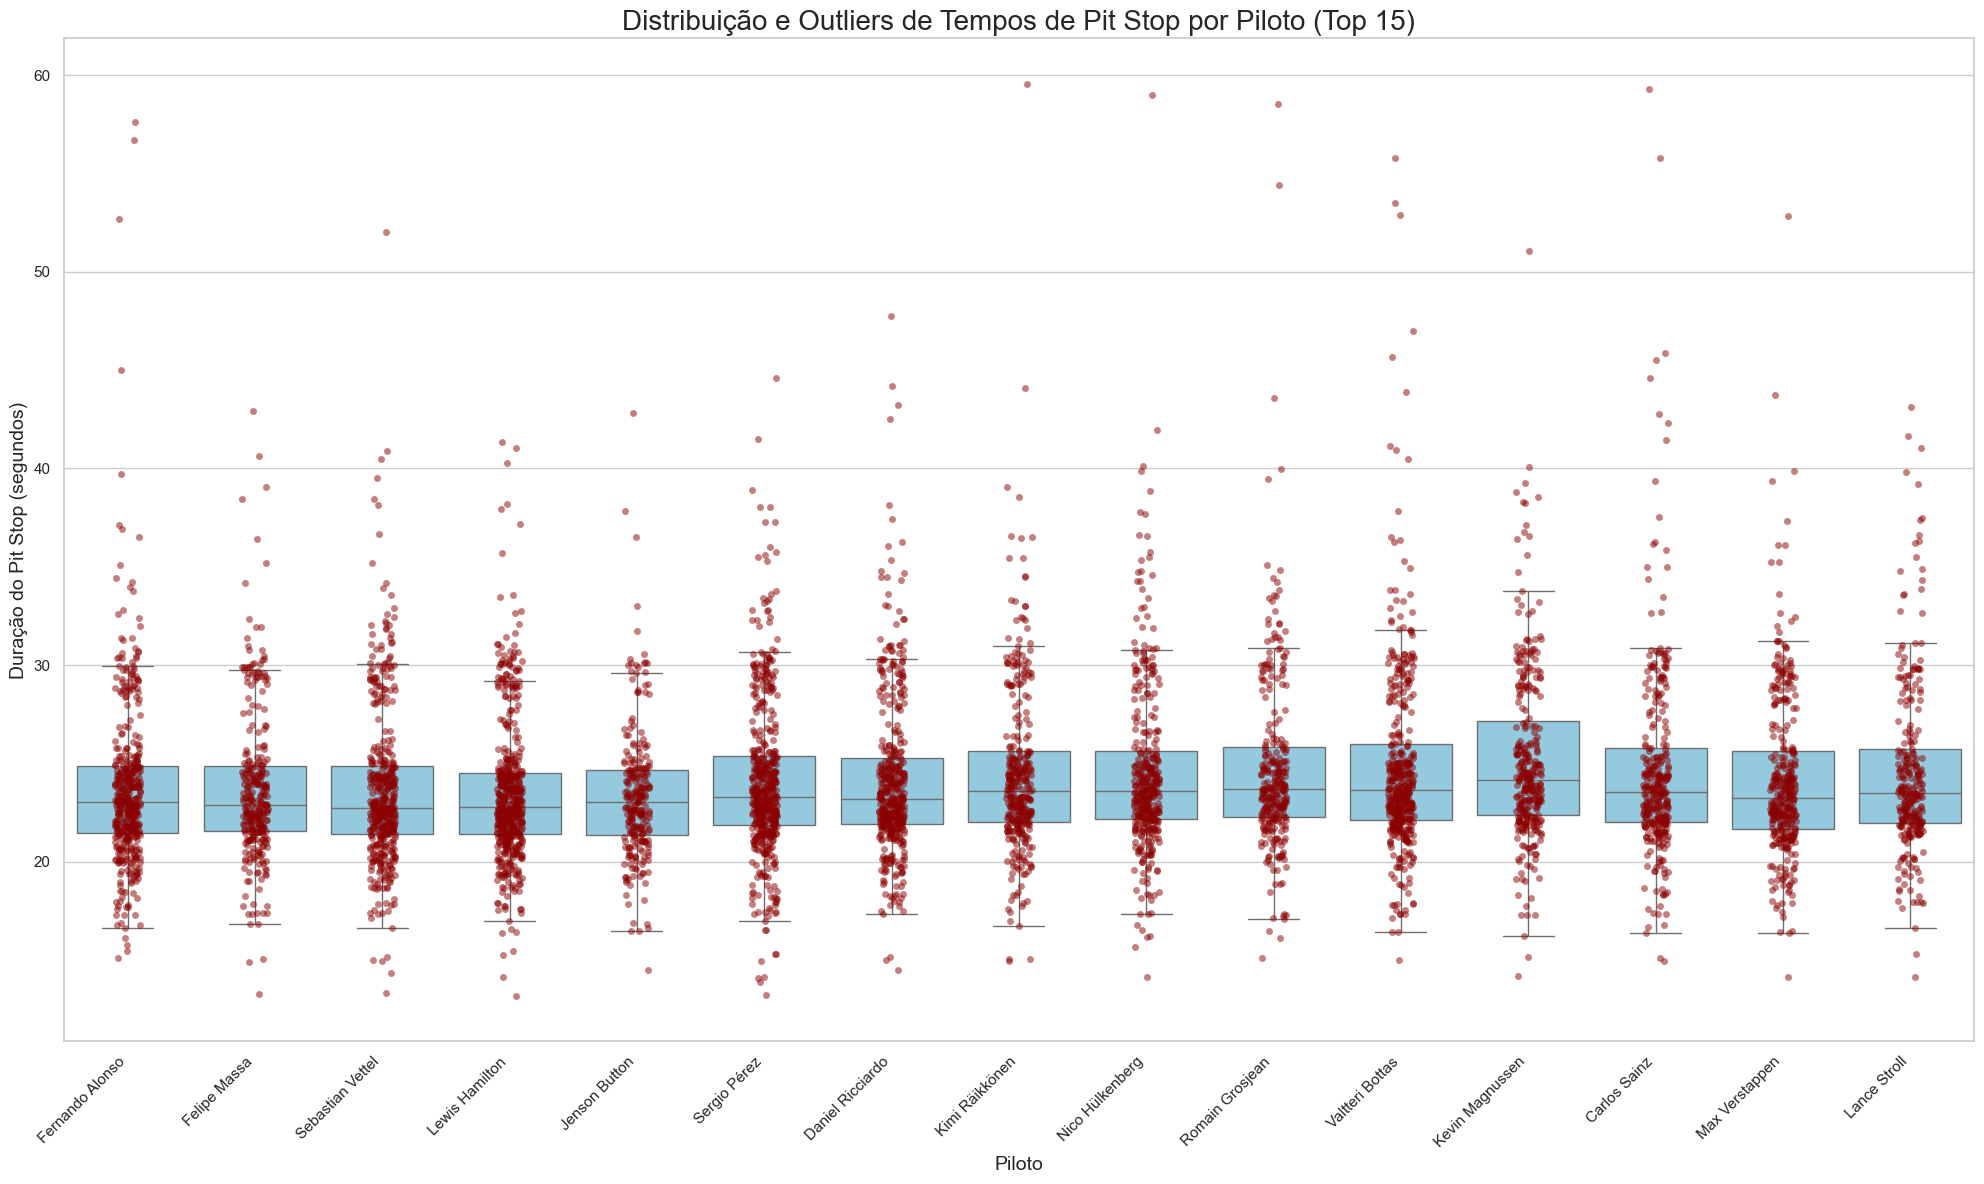

In [238]:
pit_stops_cleaned_df = dataframes['pit_stops'].withColumn(
    "duration_sec",
    when(col("duration").contains(":"),(split(col("duration"), ":").getItem(0).cast("double") * 60) + (split(col("duration"), ":").getItem(1).cast("double"))
    ).otherwise(col("duration").cast("double"))
).filter(col("duration_sec").isNotNull() & (col("duration_sec") < 60))
top_drivers_by_pitstops = pit_stops_cleaned_df.groupBy("driverId").count().orderBy(col("count").desc()).limit(15)
pit_stops_top_drivers = pit_stops_cleaned_df.join(top_drivers_by_pitstops, "driverId", "inner").join(dataframes['drivers'], "driverId", "left").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))).select("driver_name", "duration_sec")
plot_data_4 = pit_stops_top_drivers.toPandas()
plt.figure(figsize=(20, 12))
sns.boxplot(data=plot_data_4, x="driver_name", y="duration_sec", color='skyblue', showfliers=False)
sns.stripplot(data=plot_data_4, x="driver_name", y="duration_sec", color='darkred', alpha=0.5, jitter=True)
plt.title('Distribuição e Outliers de Tempos de Pit Stop por Piloto (Top 15)', fontsize=20)
plt.xlabel('Piloto', fontsize=14)
plt.ylabel('Duração do Pit Stop (segundos)', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Gráfico 5 – Pit stops por corrida (distribuição)  
- **Objetivo:** analisar impacto das paradas nos tempos totais.  
- **Ações:** junta `pit_stops` com `races` (ano) e plota histograma.  
- **Saída:** gráfico de barras com nº de pit stops por corrida.  
- **Insight esperado:** anos com mudanças de regra de pneus terão variações drásticas.  


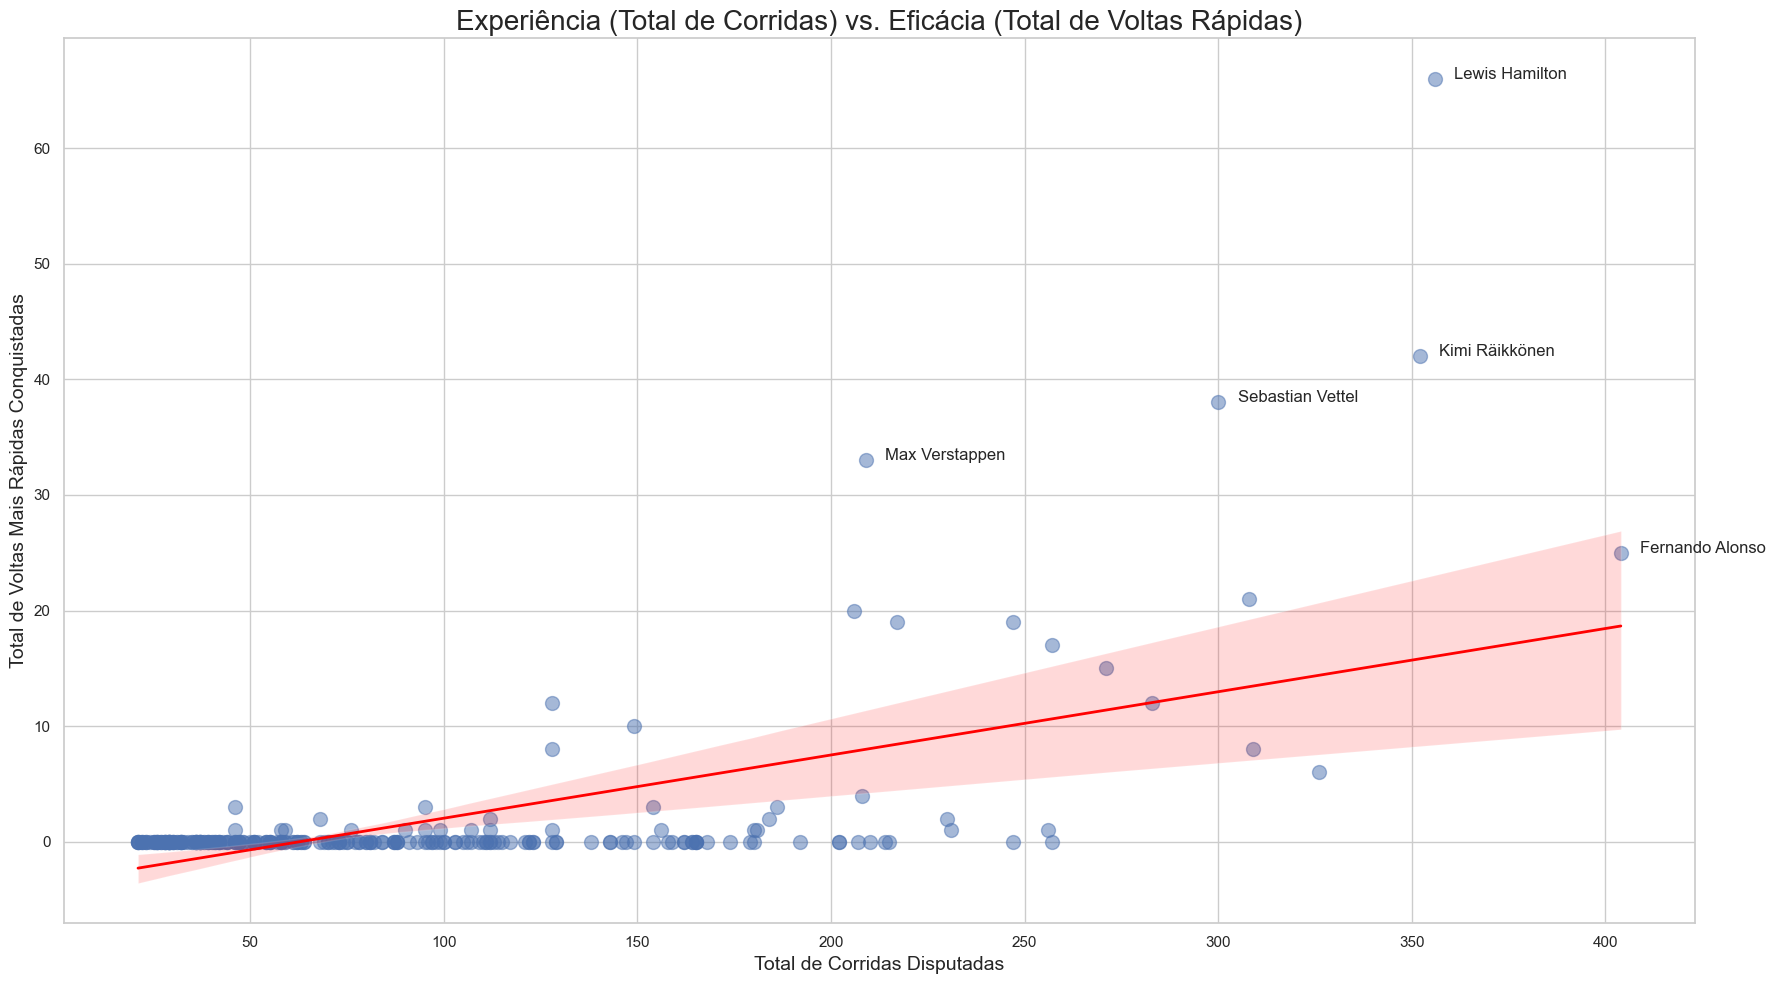

In [239]:
total_races_per_driver = dataframes['results'].groupBy("driverId").agg(spark_count("*").alias("total_races"))
total_fastest_laps_per_driver = dataframes['results'].filter(col("rank") == 1).groupBy("driverId").agg(spark_count("*").alias("total_fastest_laps"))
driver_stats_df = total_races_per_driver.join(total_fastest_laps_per_driver, "driverId", "left").fillna(0, subset=["total_fastest_laps"])
driver_stats_with_names = driver_stats_df.join(dataframes['drivers'], "driverId").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))
plot_data_5 = driver_stats_with_names.filter(col("total_races") > 20).toPandas()
plt.figure(figsize=(18, 10))
ax = sns.regplot(data=plot_data_5, x="total_races", y="total_fastest_laps", scatter_kws={'alpha': 0.5, 's': 100}, line_kws={'color': 'red', 'linewidth': 2})
plt.title('Experiência (Total de Corridas) vs. Eficácia (Total de Voltas Rápidas)', fontsize=20)
plt.xlabel('Total de Corridas Disputadas', fontsize=14)
plt.ylabel('Total de Voltas Mais Rápidas Conquistadas', fontsize=14)
outlier_pilots = plot_data_5.sort_values("total_fastest_laps", ascending=False).head(5)
for i, point in outlier_pilots.iterrows():
    ax.text(point['total_races'] + 5, point['total_fastest_laps'], point['driver_name'])
plt.grid(True)
plt.tight_layout()
plt.show()

### Gráfico 6 – Desempenho de construtores (vitórias por ano)  
- **Objetivo:** visualizar dominância de equipes.  
- **Ações:** conta vitórias (`position = 1`) em `results`, agrupado por construtor + ano.  
- **Saída:** gráfico de barras empilhadas (ano × vitórias).  
- **Insight esperado:** períodos de hegemonia (Ferrari 2000s, Mercedes 2014–2020, Red Bull 2020+). 

C:\Users\julii\AppData\Local\Temp\ipykernel_18668\605810109.py:11: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(['Mediana'], handles=[plt.Line2D([0], [0], color='red', lw=3, label='Mediana')])


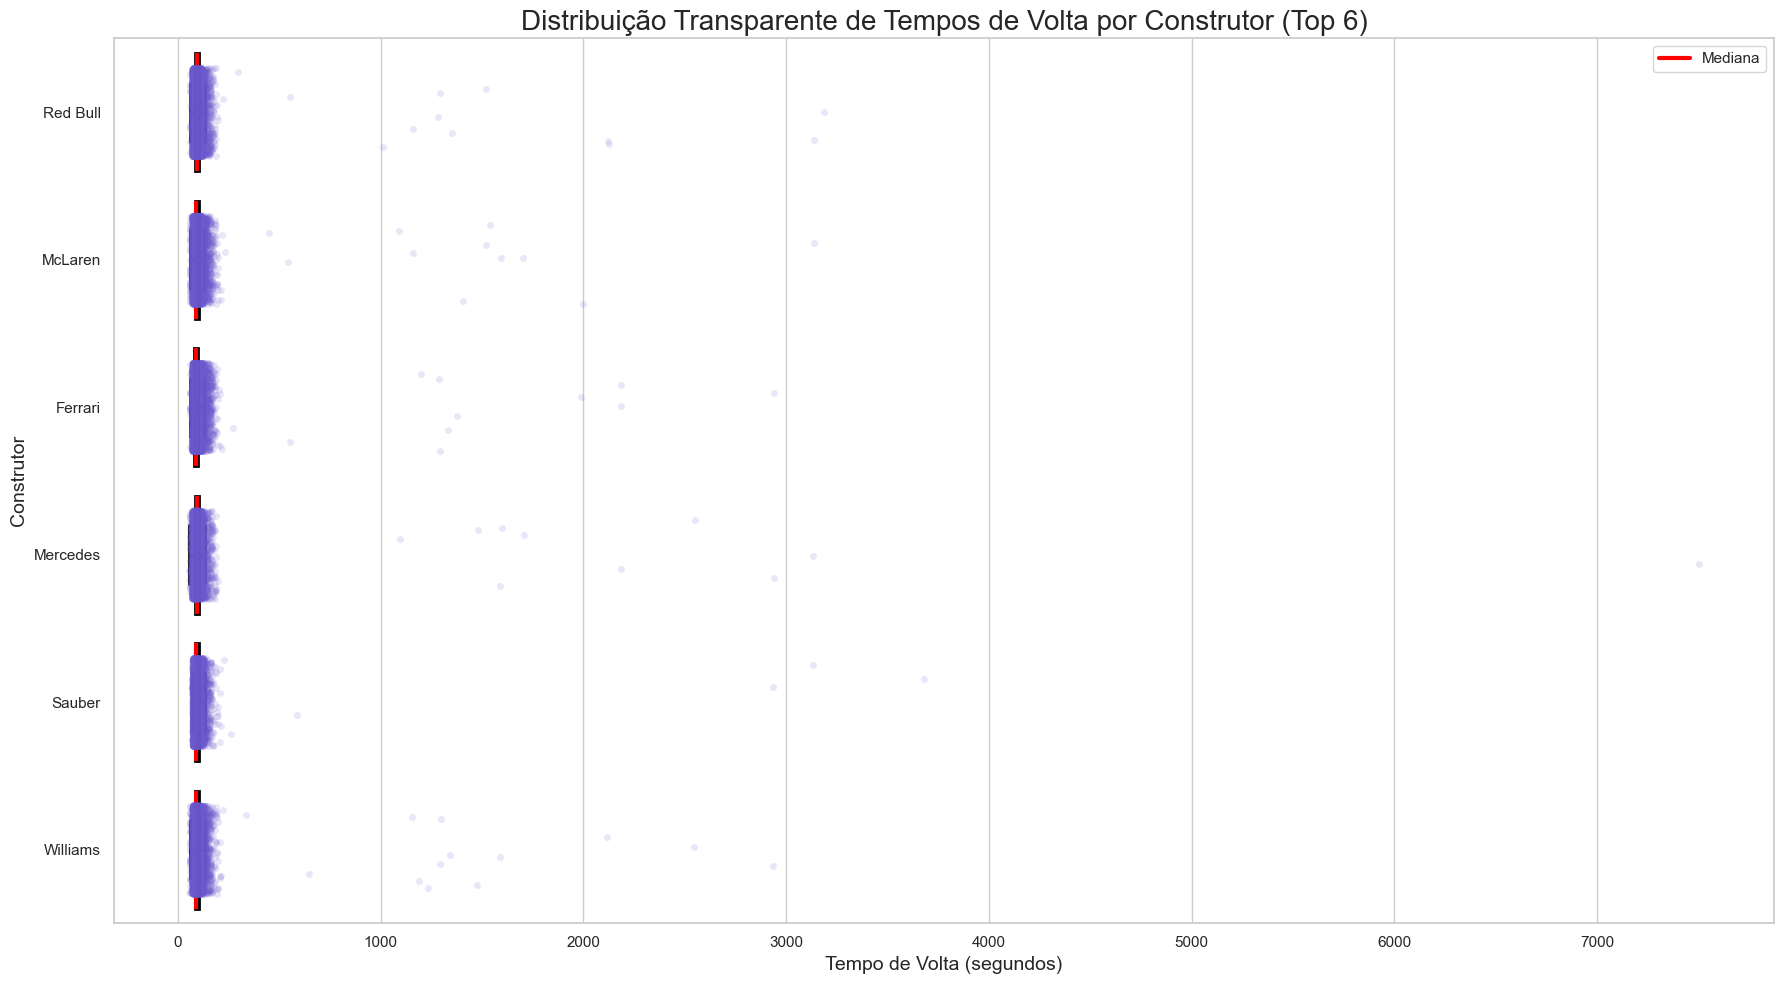

In [240]:
results_bridge = dataframes['results'].select("raceId", "driverId", "constructorId")
laps_constructors_df = dataframes['lap_times'].join(results_bridge, ["raceId", "driverId"], "left").join(dataframes['constructors'].withColumnRenamed("name", "constructor_name"), "constructorId", "left").withColumn("seconds", col("milliseconds") / 1000)
top_constructors = [row['constructor_name'] for row in laps_constructors_df.groupBy("constructor_name").count().orderBy(col("count").desc()).limit(6).collect()]
plot_data_6 = laps_constructors_df.filter(col("constructor_name").isin(top_constructors)).select("constructor_name", "seconds").sample(fraction=0.2, seed=42).toPandas()
plt.figure(figsize=(18, 10))
sns.stripplot(data=plot_data_6, y="constructor_name", x="seconds", orient='h', color='slateblue', alpha=0.15, jitter=0.3)
sns.boxplot(data=plot_data_6, y="constructor_name", x="seconds", orient='h', showfliers=False, color='none', boxprops=dict(edgecolor='black', linewidth=2), whiskerprops=dict(color='black', linewidth=2), medianprops=dict(color='red', linewidth=3), capprops=dict(color='black', linewidth=2))
plt.title('Distribuição Transparente de Tempos de Volta por Construtor (Top 6)', fontsize=20)
plt.xlabel('Tempo de Volta (segundos)', fontsize=14)
plt.ylabel('Construtor', fontsize=14)
plt.legend(['Mediana'], handles=[plt.Line2D([0], [0], color='red', lw=3, label='Mediana')])
plt.tight_layout()
plt.show()

### Gráfico 7 – Proporção de abandonos por status de corrida  
- **Objetivo:** identificar principais motivos de abandono (motor, acidente, etc.).  
- **Ações:** junta `results` com `status` e plota gráfico de pizza/top N barras.  
- **Saída:** top 10 status mais comuns de término de corrida.  
- **Insight esperado:** motores eram maiores causas antigamente; atualmente, acidentes/safety cars influenciam mais.  

C:\Users\julii\AppData\Local\Temp\ipykernel_18668\1055784470.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data_7, y="race_event_label", x="delta_sec", palette="plasma", orient='h')


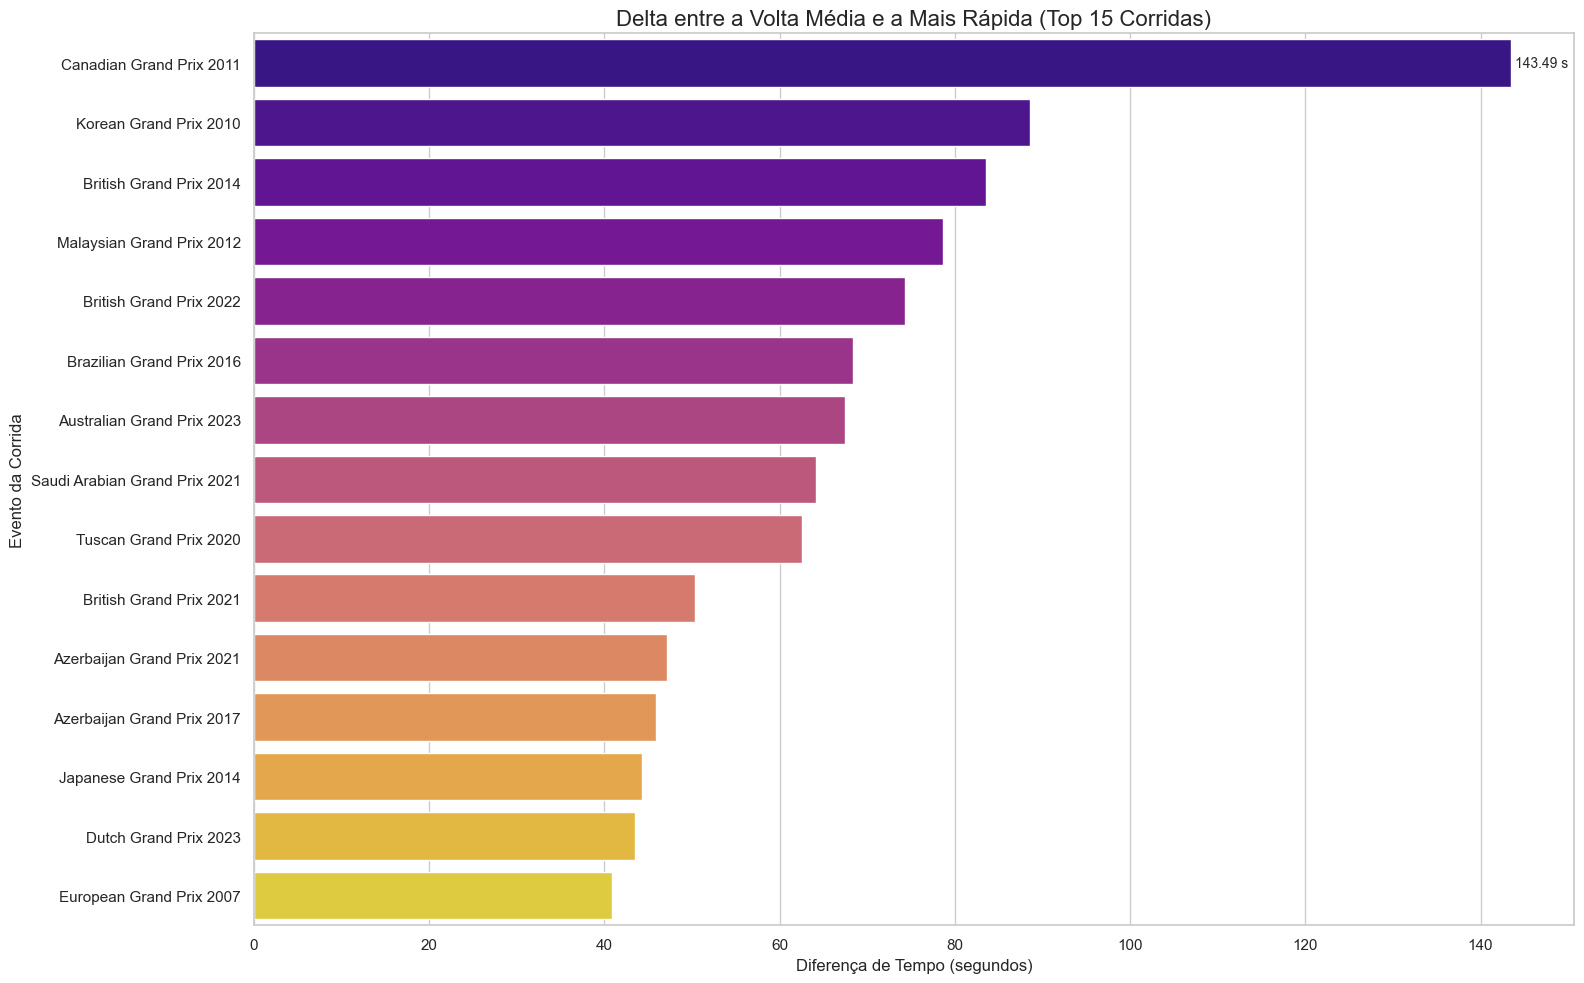

In [241]:
lap_agg_df = dataframes['lap_times'].groupBy("raceId").agg((avg("milliseconds")/1000).alias("avg_lap_sec"), (min("milliseconds")/1000).alias("fastest_lap_sec")).withColumn("delta_sec", col("avg_lap_sec") - col("fastest_lap_sec")).join(races_with_label, "raceId").orderBy(col("delta_sec").desc()).limit(15)
plot_data_7 = lap_agg_df.toPandas()
plt.figure(figsize=(16, 10))
ax = sns.barplot(data=plot_data_7, y="race_event_label", x="delta_sec", palette="plasma", orient='h')
plt.title('Delta entre a Volta Média e a Mais Rápida (Top 15 Corridas)', fontsize=16)
plt.ylabel('Evento da Corrida', fontsize=12)
plt.xlabel('Diferença de Tempo (segundos)', fontsize=12)
ax.bar_label(ax.containers[0], fmt='%.2f s', padding=3, fontsize=10)
plt.tight_layout()
plt.show()

### Gráfico 8 – Sprint Races (tempos médios × anos)  
- **Objetivo:** analisar impacto das corridas sprint.  
- **Ações:** junta `sprint_results` + `races` e calcula tempo médio.  
- **Saída:** gráfico de linha com médias por ano.  
- **Insight esperado:** avaliar se sprint mantém padrão de performance em relação às corridas principais.  


--- GRÁFICO 8: Análise de status de corrida ---


C:\Users\julii\AppData\Local\Temp\ipykernel_18668\2721572611.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data_8, y="status", x="count", palette="Set2", orient='h')


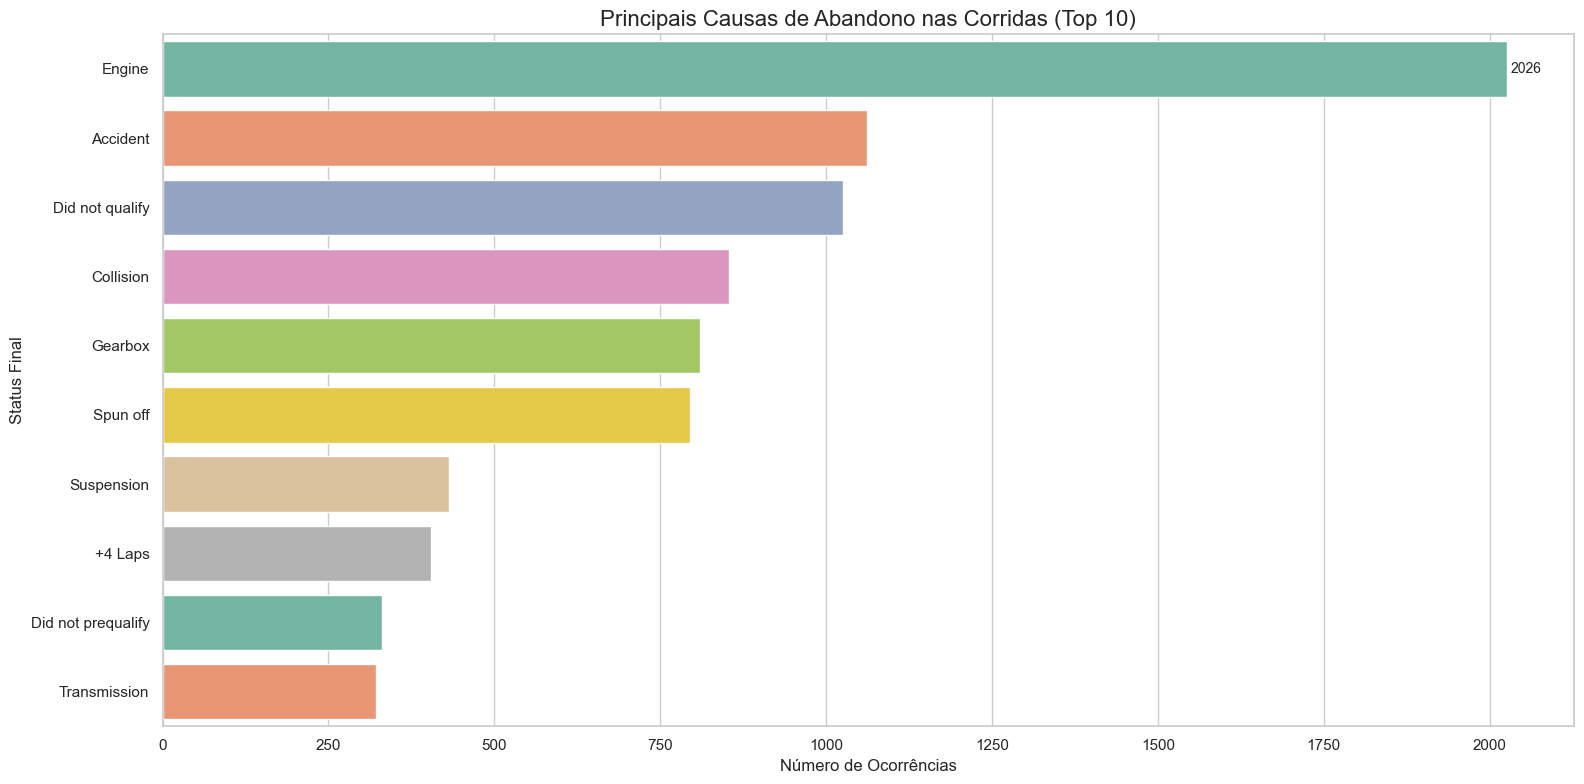

In [242]:
print("\n--- GRÁFICO 8: Análise de status de corrida ---")
status_df = dataframes['results'].join(dataframes['status'], "statusId", "left").filter(~col("status").isin(["Finished", "+1 Lap", "+2 Laps", "+3 Laps"])).groupBy("status").count().orderBy(col("count").desc()).limit(10)
plot_data_8 = status_df.toPandas()
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=plot_data_8, y="status", x="count", palette="Set2", orient='h')
plt.title('Principais Causas de Abandono nas Corridas (Top 10)', fontsize=16)
plt.ylabel('Status Final', fontsize=12)
plt.xlabel('Número de Ocorrências', fontsize=12)
ax.bar_label(ax.containers[0], padding=3, fontsize=10)
plt.tight_layout()
plt.show()


--- GRÁFICO 9: Média de voltas por piloto de 2024 round 24 (gap p/ mais rapido) ---


C:\Users\julii\AppData\Local\Temp\ipykernel_18668\1068002564.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data_9, y="driver_name", x="gap_sec", palette="rocket_r", orient='h')


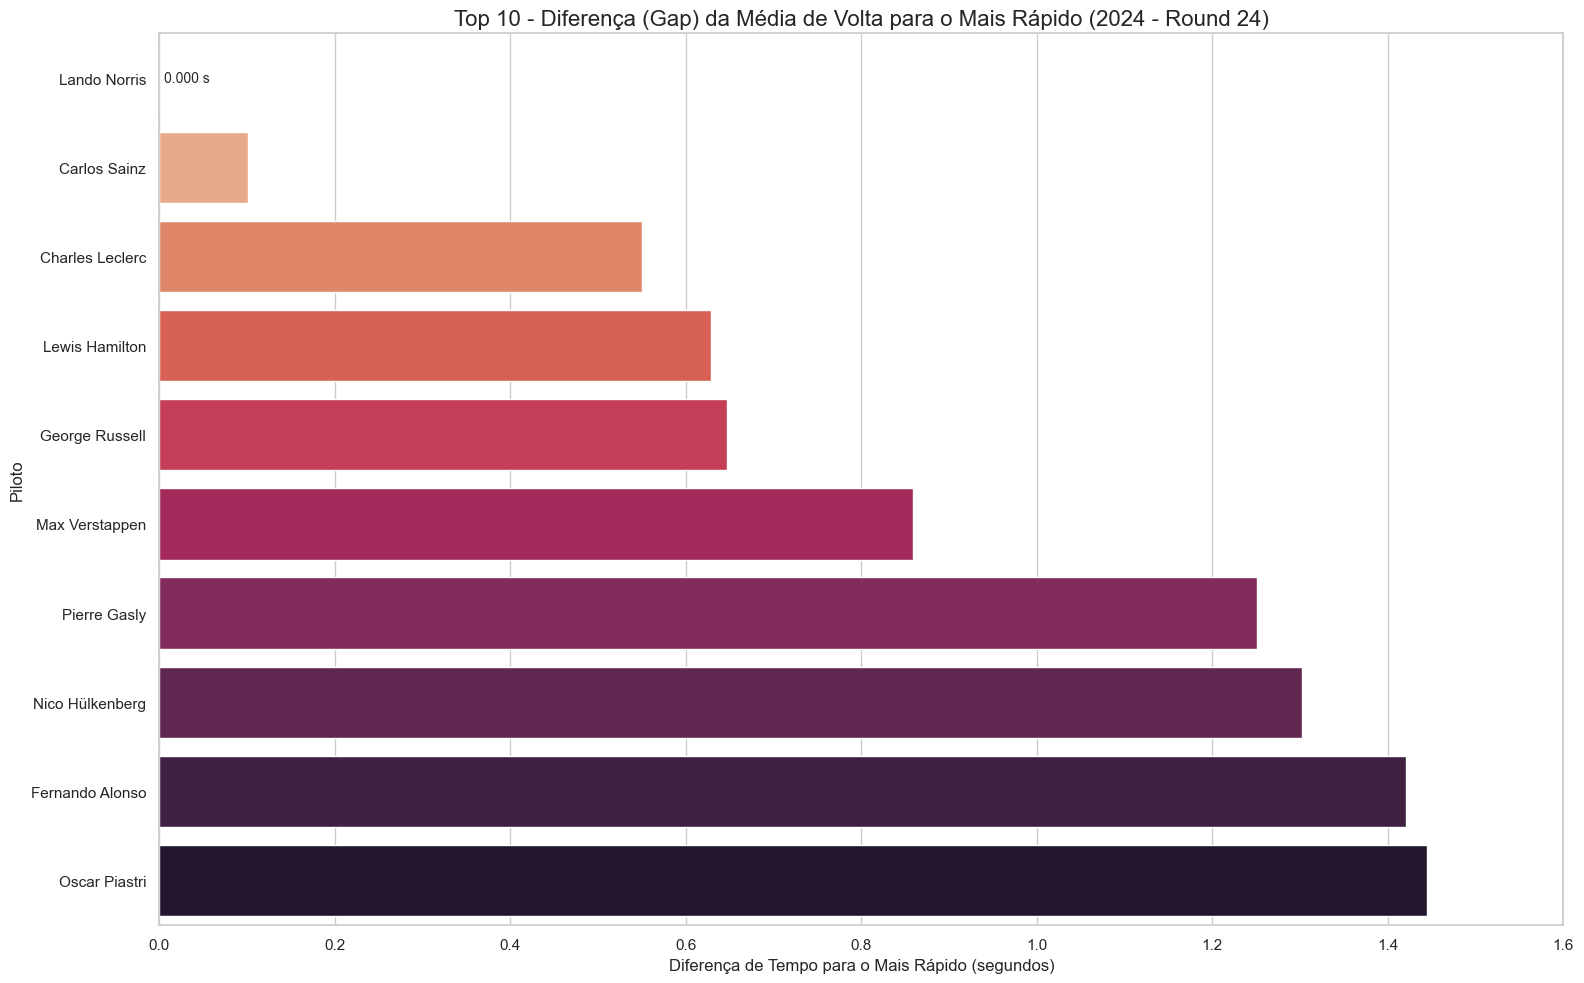

In [243]:
# --- 9. Média de voltas por piloto de 2024 round 24 (gap p/ mais rapido) ---
print("\n--- GRÁFICO 9: Média de voltas por piloto de 2024 round 24 (gap p/ mais rapido) ---")

# Para esta análise, precisamos da função Window para calcular o mínimo dentro de um grupo (a corrida)
from pyspark.sql.window import Window

# Estrutura em uma única operação encadeada, similar ao Gráfico 8
driver_gap_df = dataframes['races'] \
    .filter((col("year") == 2024) & (col("round") == 24)) \
    .join(dataframes['lap_times'], "raceId") \
    .groupBy("raceId", "driverId") \
    .agg(avg("milliseconds").alias("avg_milliseconds")) \
    .withColumn("fastest_avg_ms", min("avg_milliseconds").over(Window.partitionBy("raceId"))) \
    .withColumn("gap_sec", (col("avg_milliseconds") - col("fastest_avg_ms")) / 1000) \
    .join(dataframes['drivers'], "driverId") \
    .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
    .orderBy("gap_sec") \
    .limit(10) \
    .select("driver_name", "gap_sec")

# Converte para Pandas e verifica se há dados antes de plotar
plot_data_9 = driver_gap_df.toPandas()

if plot_data_9.empty:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada ou sem dados de volta. Gráfico 9 será pulado.")
else:
    plt.figure(figsize=(16, 10))
    ax = sns.barplot(data=plot_data_9, y="driver_name", x="gap_sec", palette="rocket_r", orient='h')
    plt.title('Top 10 - Diferença (Gap) da Média de Volta para o Mais Rápido (2024 - Round 24)', fontsize=16)
    plt.ylabel('Piloto', fontsize=12)
    plt.xlabel('Diferença de Tempo para o Mais Rápido (segundos)', fontsize=12)
    
    # Adiciona o rótulo em cada barra
    ax.bar_label(ax.containers[0], fmt='%.3f s', padding=3, fontsize=10)
    
    # Define os marcadores (ticks) do eixo X para variar de 0.2 em 0.2
    max_gap = plot_data_9['gap_sec'].max()
    # Gera uma lista de ticks até o valor máximo. Ex: se max_gap=0.75, os ticks serão [0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i * 0.2 for i in range(int(max_gap / 0.2) + 2)]
    ax.set_xticks(ticks)
    
    plt.tight_layout()
    plt.show()


--- GRÁFICO 10: Evolução do tempo médio por volta - 2024 Round 24 ---


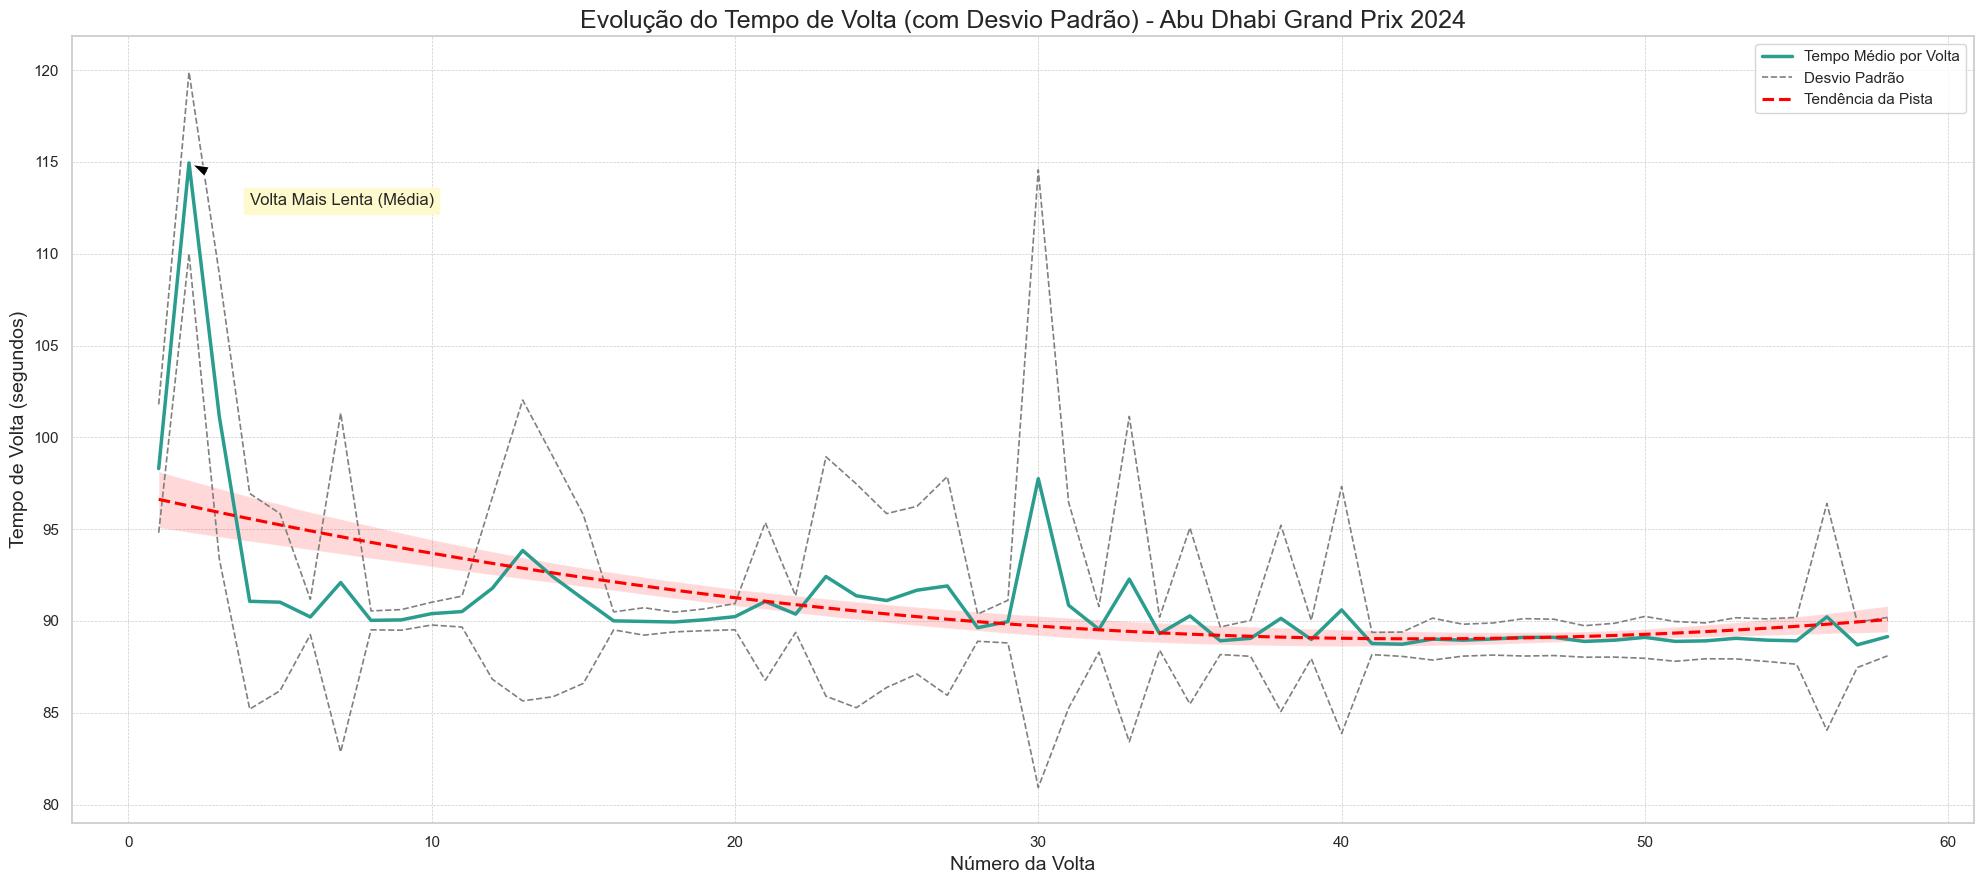

In [244]:
# --- 10. Evolução do tempo médio por volta - 2024 Round 24 (com desvio padrão em linhas) ---
print("\n--- GRÁFICO 10: Evolução do tempo médio por volta - 2024 Round 24 ---")

# Etapa 1: Encontrar as informações da corrida alvo (2024, Round 24)
target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

# Etapa 2: Verificar se a corrida existe nos dados
if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 10 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    # Etapa 3: Selecionar TODOS os tempos de volta da corrida, já convertidos para segundos.
    lap_times_df = dataframes['lap_times'] \
        .filter(col("raceId") == target_race_id) \
        .withColumn("time_in_seconds", col("milliseconds") / 1000) \
        .select("lap", "time_in_seconds")

    # Etapa 4: Converter para Pandas e verificar se há dados
    plot_data_10 = lap_times_df.toPandas()

    if plot_data_10.empty:
        print(f"AVISO: Não há dados de tempo de volta para a corrida '{target_race_name} 2024'. Gráfico 10 será pulado.")
    else:
        # Etapa 5: Calcular as estatísticas (média, desvio padrão) manualmente
        lap_stats = plot_data_10.groupby('lap')['time_in_seconds'].agg(['mean', 'std']).reset_index()
        lap_stats['upper_bound'] = lap_stats['mean'] + lap_stats['std']
        lap_stats['lower_bound'] = lap_stats['mean'] - lap_stats['std']

        # Etapa 6: Criar o gráfico
        plt.figure(figsize=(20, 9))
        ax = plt.gca() # Obter os eixos do gráfico para plotar tudo junto

        # Plotar a linha do tempo médio
        sns.lineplot(data=lap_stats, x='lap', y='mean', color='#2a9d8f', linewidth=2.5, label='Tempo Médio por Volta', ax=ax)

        # Plotar as linhas de desvio padrão (superior e inferior)
        ax.plot(lap_stats['lap'], lap_stats['upper_bound'], color='gray', linestyle='--', linewidth=1.2, label='Desvio Padrão')
        ax.plot(lap_stats['lap'], lap_stats['lower_bound'], color='gray', linestyle='--', linewidth=1.2)
        
        # Adicionar a linha de tendência vermelha e pontilhada sobre o mesmo eixo
        sns.regplot(data=plot_data_10, x='lap', y='time_in_seconds', scatter=False, color='red', order=2, ax=ax, line_kws={'linestyle':'--'}, label='Tendência da Pista')

        # Etapa 7: Melhorar o visual do gráfico
        plt.title(f'Evolução do Tempo de Volta (com Desvio Padrão) - {target_race_name} 2024', fontsize=18)
        plt.xlabel('Número da Volta', fontsize=14)
        plt.ylabel('Tempo de Volta (segundos)', fontsize=14)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # Anotação na volta com a maior média de tempo
        slowest_lap = lap_stats.loc[lap_stats['mean'].idxmax()]
        ax.annotate('Volta Mais Lenta (Média)',
                    xy=(slowest_lap['lap'], slowest_lap['mean']),
                    xytext=(slowest_lap['lap'] + 2, slowest_lap['mean'] * 0.98),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                    fontsize=12,
                    backgroundcolor='#FFFACD')
        
        # Organizar a legenda para não ter entradas duplicadas
        handles, labels = ax.get_legend_handles_labels()
        # A ordem pode variar, então criamos um dicionário para garantir uma legenda única e ordenada
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.show()


--- GRÁFICO 11: Heatmap do Gap por Volta (Top 10 Pilotos) ---


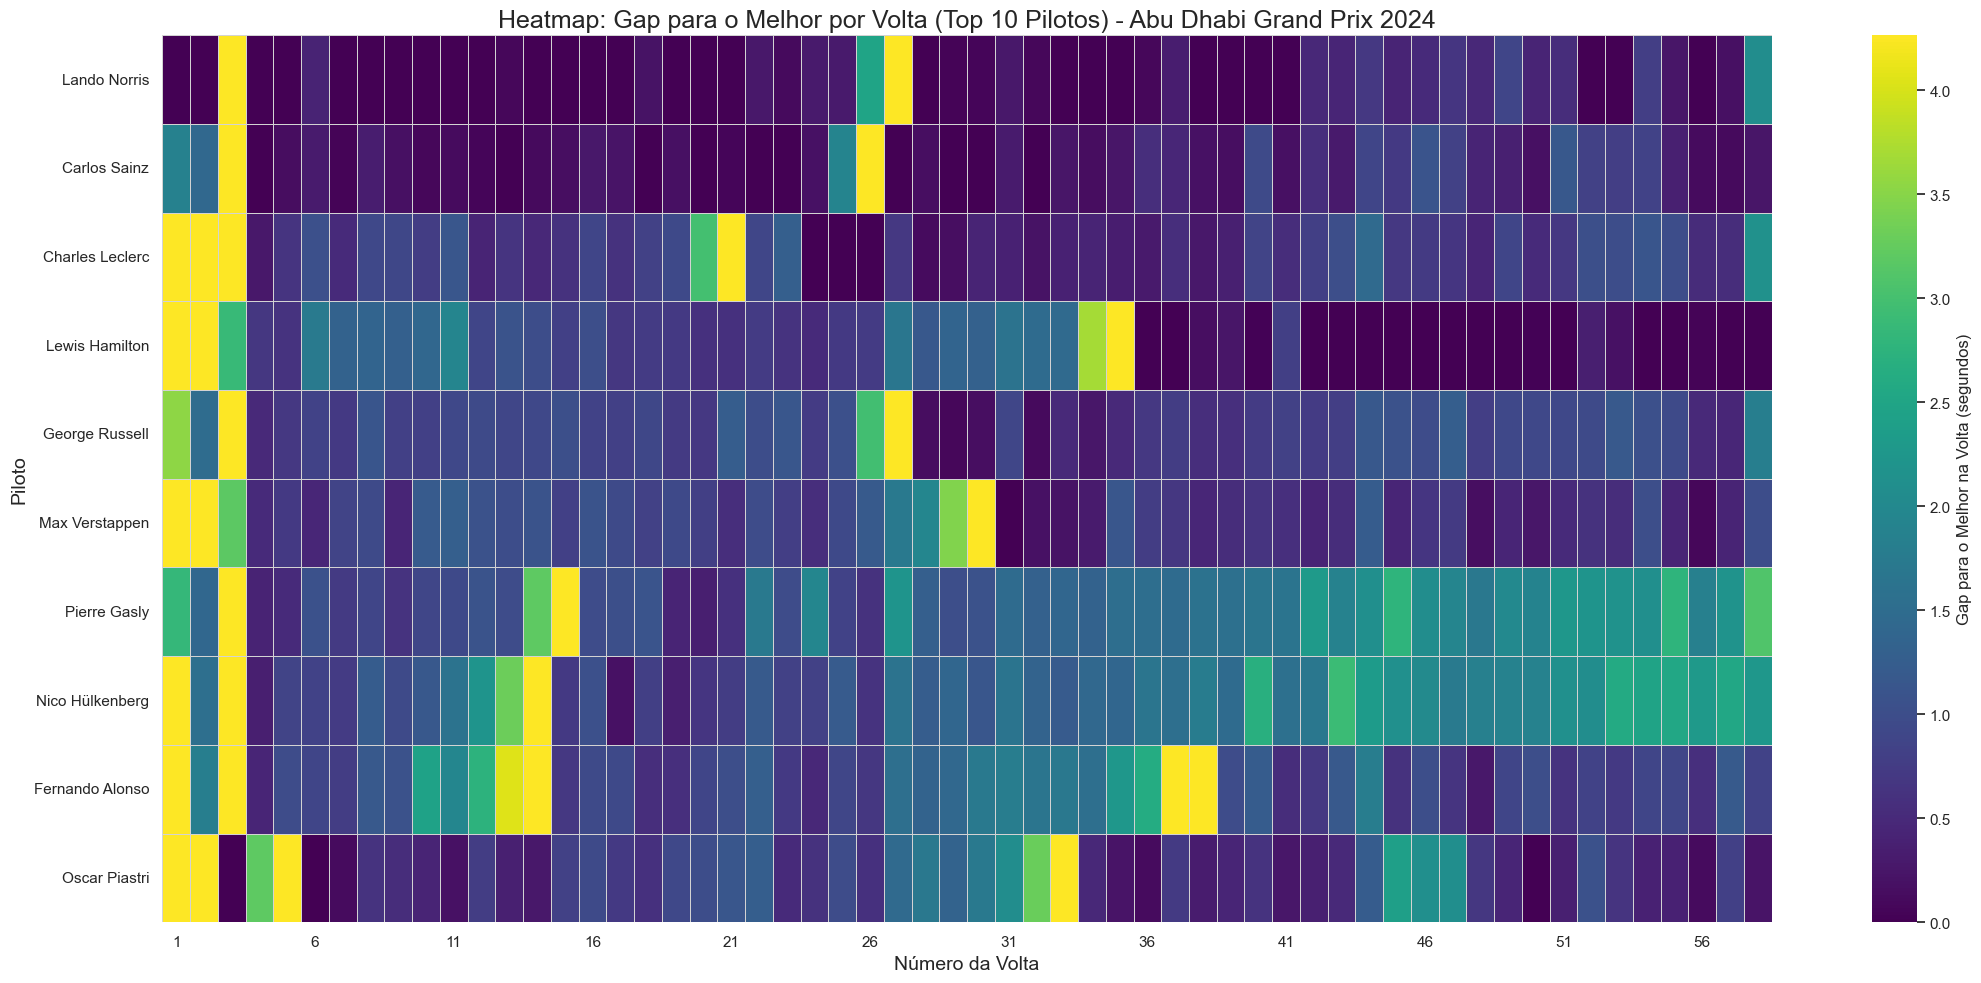

In [245]:
# --- 11. Heatmap do Gap por Volta (Top 10 Pilotos) - Versão Melhorada ---
print("\n--- GRÁFICO 11: Heatmap do Gap por Volta (Top 10 Pilotos) ---")

# Etapa 1: Encontrar as informações da corrida alvo (2024, Round 24)
target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

# Etapa 2: Verificar se a corrida existe nos dados
if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 11 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    # Etapa 3: Identificar os IDs dos 10 primeiros colocados na corrida
    top_10_driver_rows = dataframes['results'] \
        .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
        .orderBy("positionOrder") \
        .select("driverId") \
        .collect()
    
    top_10_driver_ids = [row['driverId'] for row in top_10_driver_rows]

    if not top_10_driver_ids:
        print(f"AVISO: Não há dados de resultado para a corrida '{target_race_name} 2024'. Gráfico 11 será pulado.")
    else:
        # Etapa 4: Calcular o gap de cada volta para os top 10 pilotos
        window_lap = Window.partitionBy("lap")
        lap_gaps_df = dataframes['lap_times'] \
            .filter((col("raceId") == target_race_id) & col("driverId").isin(top_10_driver_ids)) \
            .withColumn("fastest_lap_ms", min("milliseconds").over(window_lap)) \
            .withColumn("gap_sec", (col("milliseconds") - col("fastest_lap_ms")) / 1000)

        # Etapa 5: Juntar com nomes dos pilotos e selecionar dados para o heatmap
        heatmap_data_df = lap_gaps_df \
            .join(dataframes['drivers'], "driverId") \
            .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
            .select("driver_name", "lap", "gap_sec")
        
        # Etapa 6: Converter para Pandas e pivotar a tabela
        plot_data_11_unpivoted = heatmap_data_df.toPandas()
        
        if plot_data_11_unpivoted.empty:
             print(f"AVISO: Não há dados de tempo de volta para os pilotos da corrida '{target_race_name} 2024'. Gráfico 11 será pulado.")
        else:
            # Reordenar os pilotos pela ordem de chegada na corrida
            driver_order_rows = dataframes['results'] \
                .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
                .join(dataframes['drivers'], "driverId") \
                .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
                .orderBy("positionOrder") \
                .select("driver_name") \
                .collect()
            
            driver_order = [row['driver_name'] for row in driver_order_rows]

            heatmap_pivot = plot_data_11_unpivoted.pivot_table(
                index='driver_name', columns='lap', values='gap_sec'
            ).reindex(driver_order)

            # Etapa 7: Criar o heatmap com melhorias visuais
            
            # Calcula um limite superior para a barra de cores para melhorar o contraste
            vmax_cap = plot_data_11_unpivoted['gap_sec'].quantile(0.95)

            # Aplica um estilo temporário para um fundo mais limpo
            with sns.axes_style("white"):
                plt.figure(figsize=(22, 10)) # Aumenta a altura
                ax = sns.heatmap(
                    heatmap_pivot,
                    cmap='viridis',
                    vmax=vmax_cap,  # Limita a escala de cor para melhor contraste
                    linewidths=.5,  # Adiciona linhas entre as células
                    linecolor='lightgray', # Define a cor das linhas
                    cbar_kws={'label': 'Gap para o Melhor na Volta (segundos)'}
                )
                ax.set_title(f'Heatmap: Gap para o Melhor por Volta (Top 10 Pilotos) - {target_race_name} 2024', fontsize=18)
                ax.set_xlabel('Número da Volta', fontsize=14)
                ax.set_ylabel('Piloto', fontsize=14)
                
                # Otimiza os marcadores do eixo X
                xticks = ax.get_xticks()
                xticklabels = ax.get_xticklabels()
                ax.set_xticks(xticks[::5])
                ax.set_xticklabels([xt.get_text() for xt in xticklabels][::5], rotation=0)

                plt.tight_layout()
                plt.show()


--- GRÁFICO 12: Posição em Pista vs. Tempo de Corrida (Top 10) ---


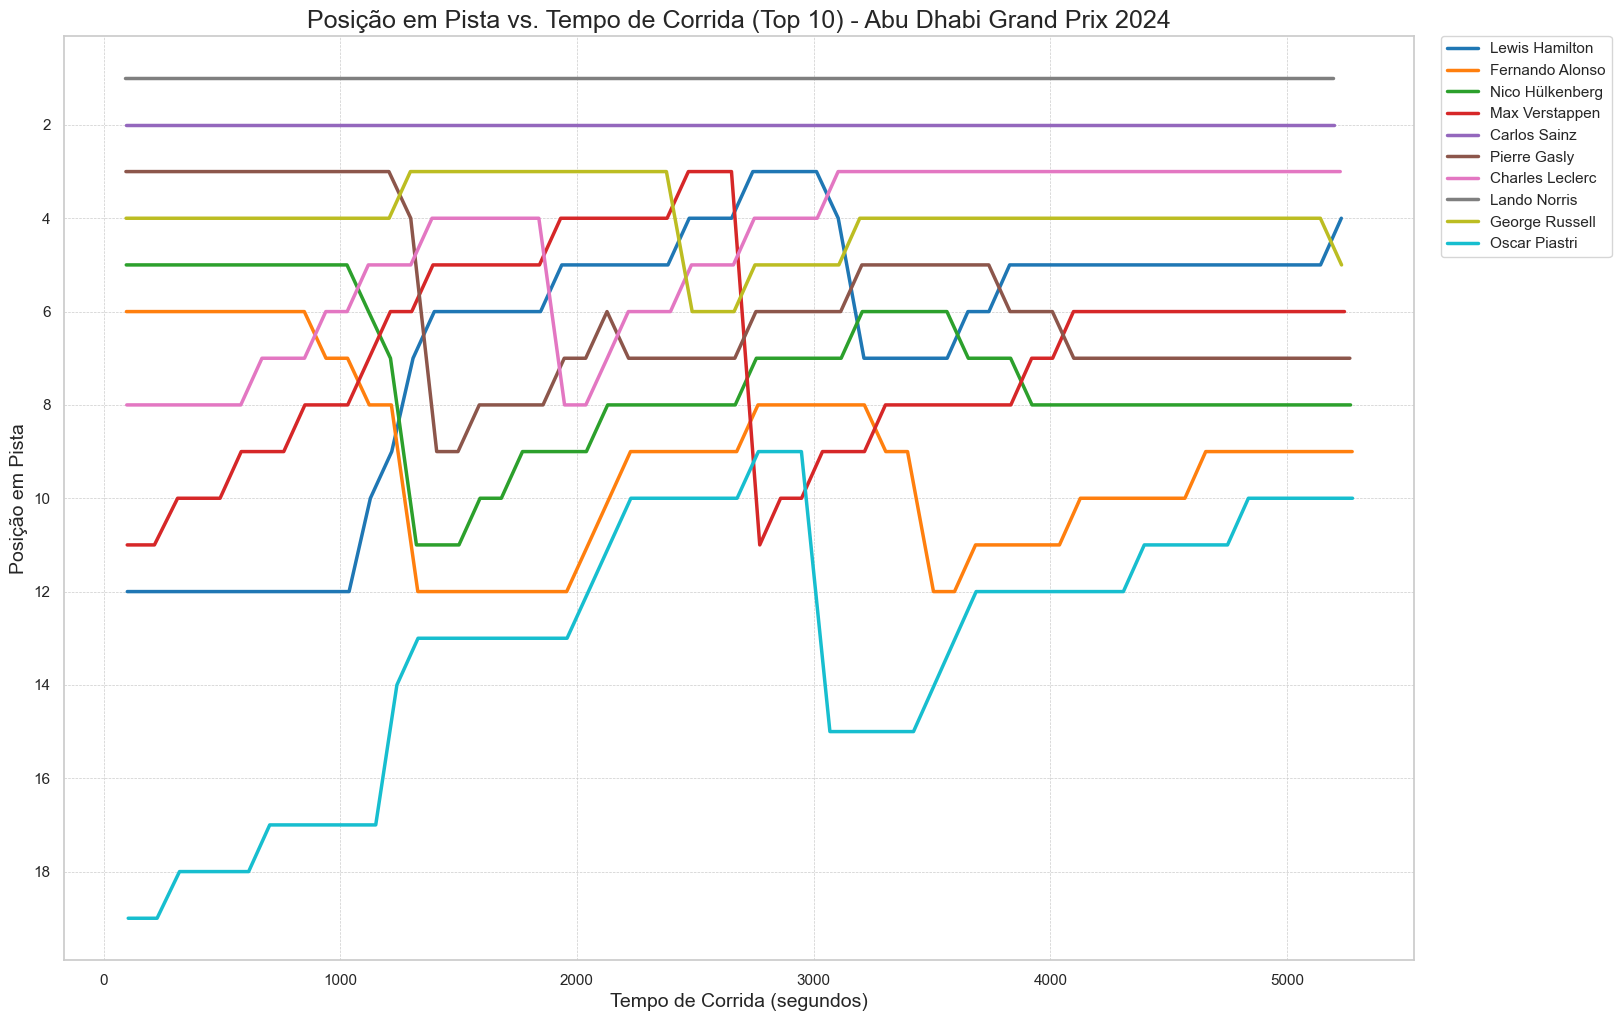

In [ ]:

print("\n--- GRÁFICO 12: Posição em Pista vs. Tempo de Corrida (Top 10) ---")

# Importações necessárias para a janela de soma e para formatar os eixos do gráfico
from pyspark.sql.functions import sum as spark_sum
from matplotlib.ticker import MaxNLocator

# Etapa 1: Encontrar as informações da corrida alvo (2024, Round 24)
target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

# Etapa 2: Verificar se a corrida existe nos dados
if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 12 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    # Etapa 3: Identificar os IDs dos 10 primeiros colocados na corrida
    top_10_driver_rows = dataframes['results'] \
        .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
        .select("driverId") \
        .collect()
    top_10_driver_ids = [row['driverId'] for row in top_10_driver_rows]

    if not top_10_driver_ids:
        print(f"AVISO: Não há dados de resultado para a corrida '{target_race_name} 2024'. Gráfico 12 será pulado.")
    else:
        # Etapa 4: Calcular o tempo acumulado para cada piloto a cada volta
        window_driver = Window.partitionBy("driverId").orderBy("lap")
        
        race_progression_df = dataframes['lap_times'] \
            .filter((col("raceId") == target_race_id) & col("driverId").isin(top_10_driver_ids)) \
            .withColumn("cumulative_time_sec", spark_sum("milliseconds").over(window_driver) / 1000) \
            .join(dataframes['drivers'], "driverId") \
            .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
            .select("driver_name", "cumulative_time_sec", "position")

        # Etapa 5: Converter para Pandas e verificar se há dados para plotar
        plot_data_12 = race_progression_df.toPandas()

        if plot_data_12.empty:
            print(f"AVISO: Não há dados de tempo de volta para os pilotos da corrida '{target_race_name} 2024'. Gráfico 12 será pulado.")
        else:
            # Etapa 6: Criar o gráfico de progressão da corrida
            plt.figure(figsize=(20, 12))
            ax = sns.lineplot(
                data=plot_data_12,
                x='cumulative_time_sec',
                y='position',
                hue='driver_name',
                palette='tab10',  # Paleta de cores boa para distinguir até 10 linhas
                linewidth=2.5
            )

            # Etapa 7: Ajustar e formatar o gráfico
            ax.invert_yaxis() # Inverte o eixo Y para que a P1 fique no topo
            ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # Força os marcadores do eixo Y a serem inteiros
            
            ax.set_title(f'Posição em Pista vs. Tempo de Corrida (Top 10) - {target_race_name} 2024', fontsize=18)
            ax.set_xlabel('Tempo de Corrida (segundos)', fontsize=14)
            ax.set_ylabel('Posição em Pista', fontsize=14)
            
            # Posiciona a legenda fora da área do gráfico para não obstruir as linhas
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            # Usa 'subplots_adjust' para garantir que a legenda não seja cortada
            plt.subplots_adjust(right=0.8) 
            plt.show()

In [247]:
spark.stop()